In [1]:
import os
import numpy as np

import cytopath
import scvelo as scv

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def undirected_simulations(adata, num_sim):
    
    adata.obs['all_ends'] = 'end'
    adata.obs['all_ends'] =  adata.obs['all_ends'].astype('category')
    cytopath.sampling(adata, sim_number=num_sim, traj_number=num_sim,
                      max_steps=30, cluster_key='all_ends', min_clusters=1,
                      root_cells=np.arange(adata.shape[0]), 
                      end_points=np.arange(adata.shape[0]),
                      auto_adjust=False, num_cores=40)
    
    cells, counts = np.unique(adata.uns['samples']['cell_sequences'][:, -1], return_counts=True)
    adata.obs['terminal_state_freq'] = float(np.nan)
    adata.obs.iloc[cells, adata.obs.columns.get_loc('terminal_state_freq')] = counts
    adata.obs['log_terminal_state_freq'] = np.log(adata.obs['terminal_state_freq']+1)
    
    return adata

def minmaxscale(array):
    return (array - array.min())/(array.max() - array.min())

def add_terminal_state(adata, categorical, thresh=0.99):
    adata.obs[categorical] = adata.obs[categorical].astype(str)
    adata.obs.loc[adata.obs.end_points>=thresh, categorical] = 'terminus'
    adata.obs[categorical] = adata.obs[categorical].astype('category')

In [3]:
# Load data (activity induced genes)
# Source data can be found at the link below
# https://github.com/wulabupenn/scNT-seq/blob/master/notebook_for_figures/neuron_revision_figures.ipynb

# Data with aig selected can be downloaded here
# https://drive.google.com/file/d/1su05R5yooTVlShZL0Xb7XA6iTkFkPXsZ/view?usp=sharing
adata = scv.read('scNT_seq_aig.h5ad')
adata

AnnData object with n_obs × n_vars = 3060 × 97
    obs: 'cellname', 'time', 'louvain'
    var: 'grp', 'class'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced'

In [4]:
# Preprocess data
scv.pp.filter_and_normalize(adata, min_shared_counts=5)
scv.pp.moments(adata)

scv.tl.louvain(adata)

scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)
scv.tl.terminal_states(adata)

adata.uns['T_forward'] = scv.utils.get_transition_matrix(adata, self_transitions=False)

Filtered out 16 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
The correlation threshold has been reduced to -0.3182.
Please be cautious when interpreting results.
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/52 cores)


  0%|          | 0/3060 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [5]:
# Perform undirected sampling using cytopath
adata_ = undirected_simulations(adata.copy(), 1000)
adata.obs['terminal_state_freq'] = adata_.obs['terminal_state_freq']
adata.obs['scaled_terminal_state_freq'] = minmaxscale(adata_.obs['log_terminal_state_freq'])


Sampling round: 0


  0%|          | 0/3060 [00:00<?, ?it/s]

Sampling done.


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


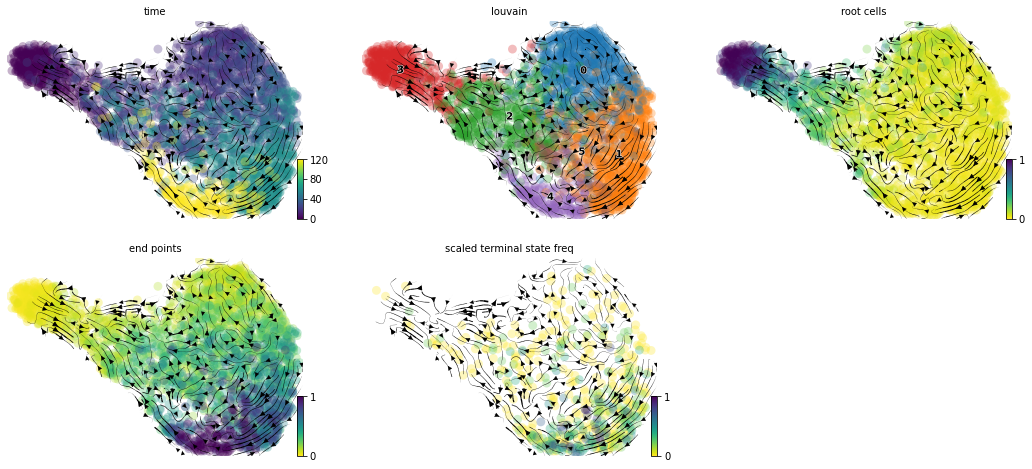

In [6]:
# Plot
scv.pl.velocity_embedding_stream(adata, ncols=3,
                                 color=['time', 'louvain', 'root_cells', 'end_points', 'scaled_terminal_state_freq'], 
                                 legend_loc='on data')

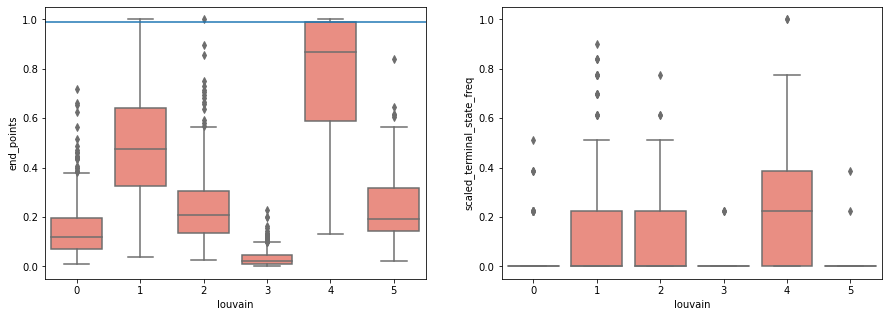

In [7]:
# Mean terminal state probability distribution
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

sns.boxplot(x='louvain', y='end_points', data=adata.obs.sort_values('end_points'), color='salmon', ax=axs[0])
axs[0].axhline(0.99)

sns.boxplot(x='louvain', y='scaled_terminal_state_freq', data=adata.obs.sort_values('scaled_terminal_state_freq'), 
            color='salmon', ax=axs[1])

# Select terminal state cells
add_terminal_state(adata, 'louvain')

In [8]:
# Run cytopath
cytopath.sampling(adata, num_cores=os.cpu_count()-1)
cytopath.trajectories(adata, num_cores=os.cpu_count()-1)

Adjusting simulation parameters based on dataset properties. Set auto_adjust=False if this is unwanted.
Number of required simulations per end point (traj_number) set to 1743
Number of initial simulations (sim_number) set to 1743
Number of initial simulation steps (max_steps) set to 18

Sampling round: 0


  0%|          | 0/67 [00:00<?, ?it/s]

Sampling done.
Stage 1 clustering done. Aligning clusters for end point terminus
Calculating hausdorff distances


  0%|          | 0/1743 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/259 [00:00<?, ?it/s]

Final clustering done. Aligning clusters for end point terminus


  0%|          | 0/259 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/1 [00:00<?, ?it/s]

Computing neighborhoods of trajectories for end point terminus at each step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  terminus


  0%|          | 0/281 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  terminus (i.e. cells neighborhood)


  0%|          | 0/1 [00:00<?, ?it/s]

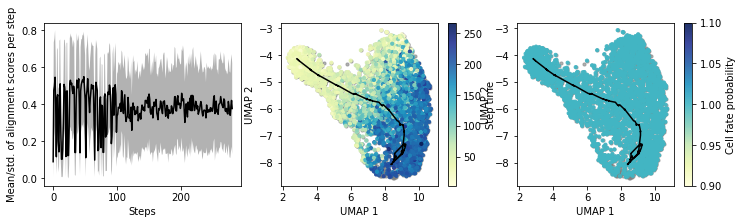

In [9]:
# Plot trajectories
cytopath.plot_trajectories(adata, basis='umap')